In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from yellowbrick.features import Rank2D
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import sklearn.linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = arff.loadarff('Autism-Adult-Data.arff')
rough = pd.DataFrame(data[0])

In [3]:
df = rough.copy()
df.shape

(704, 21)

In [4]:
# I altered this data before splitting because I wasn't inherently channging any of the values and I was going to need to complete these changes for all testing and training sets
for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = df[i].str.decode('utf-8')
for i in df.columns:
    if i[0] == 'A':
        df[i] = df[i].astype('int64')

In [5]:
# Recoding of the binary variables to a standard format
df.replace({'yes' : 1, 'no' : 0}, inplace = True)
df.replace({'YES' : 1, 'NO' : 0}, inplace = True)
df.replace({'m' : 1, 'f' : 0}, inplace = True)
# Showing high correlation of result and target variable
df[['result', 'Class/ASD']].corr()

,result,Class/ASD
result,1.000000,0.821445
Class/ASD,0.821445,1.000000


In [6]:
# I'm dropping these features due to the concerns that one hot encoding them will lead to many features being developed which is the opposite of what I am trying to accomplish with dimensionality reduction
df.drop(['used_app_before', 'age_desc', 'ethnicity', 'contry_of_res', 'relation', 'result'], axis = 1, inplace = True)
df.dropna()
df = df[df['age'] < 150]

In [7]:
seed = 19
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[:-1]],
                                                    df['Class/ASD'],
                                                    train_size=0.80,
                                                    random_state=seed,
                                                    stratify=df['Class/ASD'])

In [8]:
x_train

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim
311,0,0,1,1,1,0,0,1,0,0,36.0,1,1,0
346,1,0,0,0,1,0,1,1,1,0,21.0,1,0,0
194,0,1,0,1,0,0,0,1,0,0,31.0,1,0,1
295,1,0,1,1,1,1,0,0,1,1,45.0,0,0,0
634,1,0,1,0,1,0,1,1,1,1,22.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,1,0,1,1,0,0,0,0,0,0,39.0,1,0,1
551,1,0,0,0,1,0,0,0,0,1,42.0,0,0,1
58,1,0,0,0,1,0,0,1,0,0,32.0,0,0,1
308,1,1,1,1,1,1,0,0,1,1,25.0,0,0,0


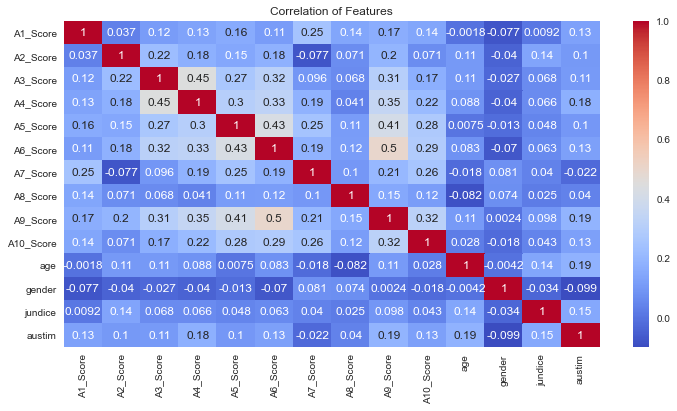

In [9]:
# correlation heatmap showing the correlation between all variables
plt.rcParams['figure.figsize'] = (12, 6)
plt.title('Correlation of Features')
sns.heatmap(x_train.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')
plt.savefig('correlation_heat.png')

In [10]:
# feature selection option 0: didn't actually do anything
# here is the binary variance thresholding for all of the binary features
scores = ['A{}_Score'.format(i+1) for i in range(10)]
scores.extend(['gender', 'jundice', 'austim'])
x_train_fun = x_train[scores]
thresholder = VarianceThreshold(threshold=(.75 * (1 - .75)))
thresholder.fit_transform(x_train_fun)
print(x_train_fun.shape)
x_train_fun

(560, 13)


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,gender,jundice,austim
311,0,0,1,1,1,0,0,1,0,0,1,1,0
346,1,0,0,0,1,0,1,1,1,0,1,0,0
194,0,1,0,1,0,0,0,1,0,0,1,0,1
295,1,0,1,1,1,1,0,0,1,1,0,0,0
634,1,0,1,0,1,0,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,1,0,1,1,0,0,0,0,0,0,1,0,1
551,1,0,0,0,1,0,0,0,0,1,0,0,1
58,1,0,0,0,1,0,0,1,0,0,0,0,1
308,1,1,1,1,1,1,0,0,1,1,0,0,0


In [11]:
# feature selection option 1
# using the selectKBest function to run a chisquared analysis on all binary variables
chi2_selector = SelectKBest(chi2, k=10)
x_train_kbest = chi2_selector.fit_transform(x_train_fun, y_train)
print(x_train_kbest.shape)
x_train_kbest

(560, 10)


array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 0, 0, ..., 0, 1, 0]], dtype=int64)

In [12]:
# feature selection option 2: Did I run this correctly? Questioning because it only leaves me with one feature
# running recursive feature elimation with a logistic regression estimate and AUCROC scoring
#  Create a logistic regression estimator 
logreg = lm.LogisticRegression()

# Use RFECV to pick best features, using Stratified Kfold
rfecv =   RFECV(estimator=logreg, step = 1, cv = 5, n_jobs = -1, scoring='roc_auc')

# Fit the features to the response variable
rfecv.fit(x_train, y_train)

# Put the best features into new df X_new
x_train_new = rfecv.transform(x_train)
x_train_new.shape

(560, 10)

In [13]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3, 4, 2])

In [14]:
scaler = StandardScaler()

# fitting the scaler to the feature training data
scaler.fit(x_train_new)

# transforming training features using fit scaler
std_features_train = scaler.transform(x_train_new)

# transforming test features using fit scaler
x_test_new = rfecv.transform(x_test)
std_features_test = scaler.transform(x_test_new)


In [15]:
std_features_test.shape

(141, 10)

In [16]:
# creation of a random forest model
randomforest = RandomForestClassifier(random_state=seed, n_jobs=-1, max_depth = 5)
model = randomforest.fit(std_features_train, y_train)
forest_pred = model.predict(std_features_test)
print('Average precision:', average_precision_score(y_test, forest_pred))
print('AUCROC:', roc_auc_score(y_test, forest_pred))

Average precision: 0.8207443798239593
AUCROC: 0.8898824731732243


C:\Programming\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


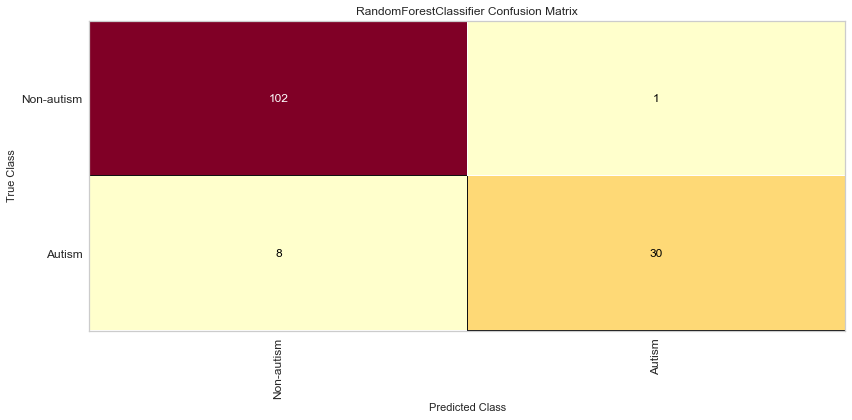

C:\Programming\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


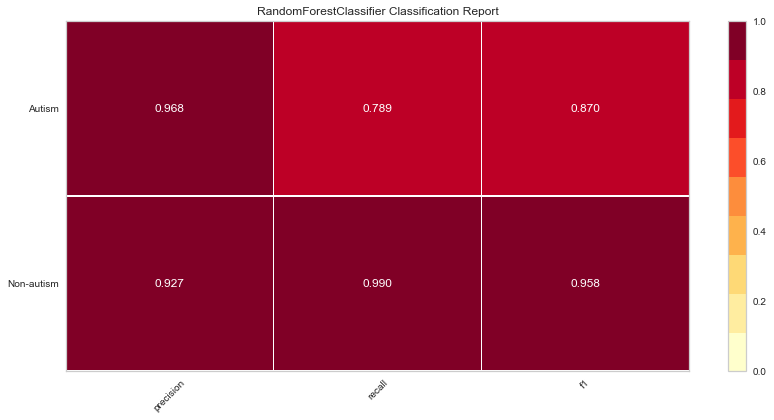

In [17]:
# confusion matrix of the random forest model
classes = ['Non-autism', 'Autism']
cm = ConfusionMatrix(model, classes=classes, percent=False)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
cm.fit(std_features_train, y_train)

#and then creates the confusion_matrix from scikit learn.
cm.score(std_features_test, y_test)
cm.show()

# Classification Report of the random forest model
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(std_features_train, y_train)  # Fit the training data to the visualizer
visualizer.score(std_features_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof(outpath = 'Class_report.png')

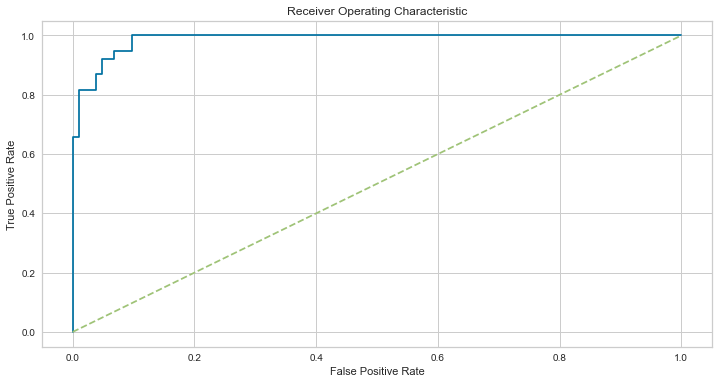

In [18]:
# ROC curve of random forest model
target_probabilities = model.predict_proba(std_features_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, target_probabilities)
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.savefig('ROC_Curve.png')
plt.show()

In [19]:
roc_auc_score(y_test, target_probabilities)

0.986969851814001

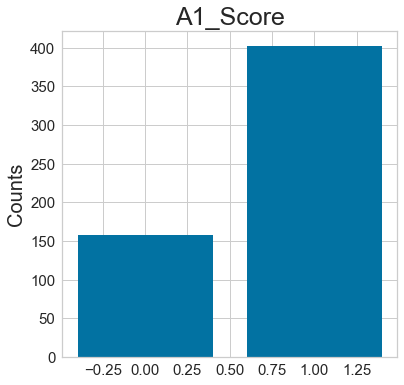

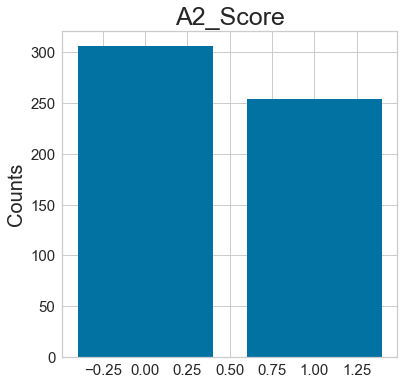

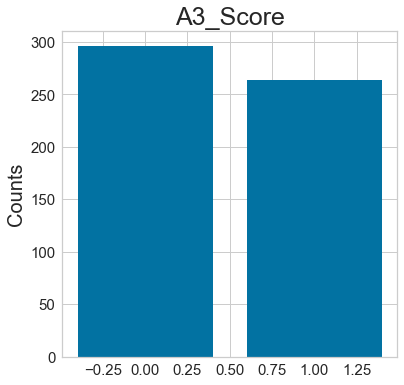

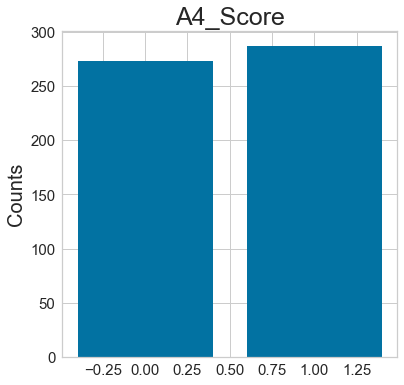

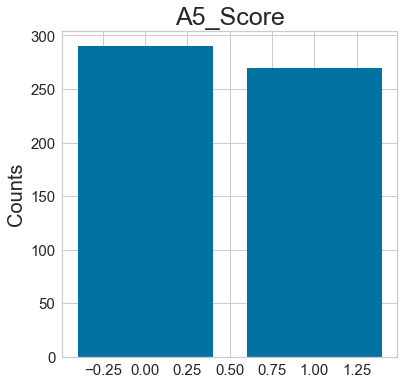

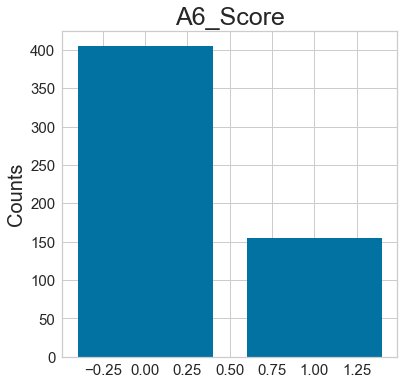

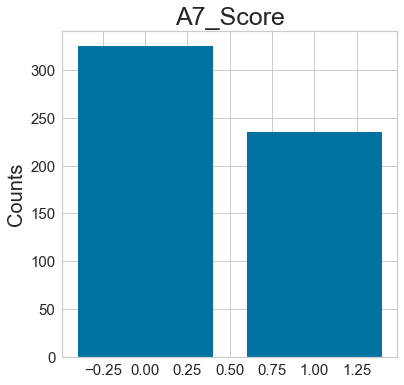

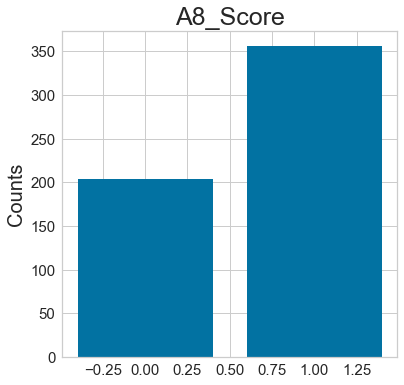

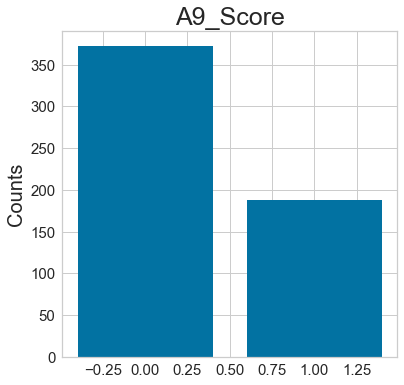

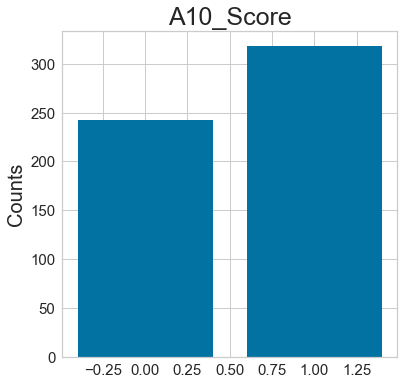

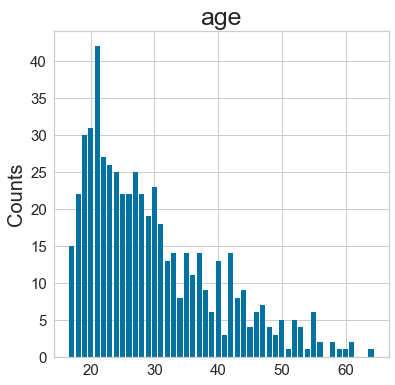

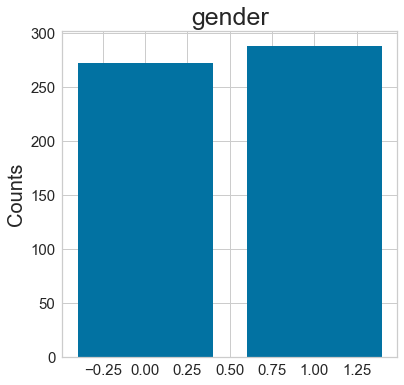

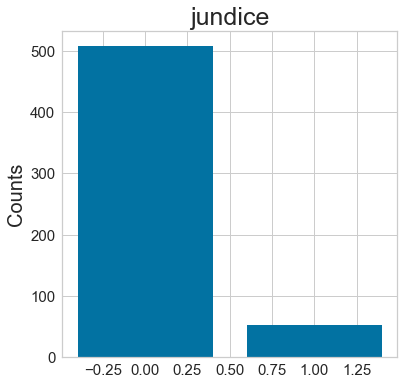

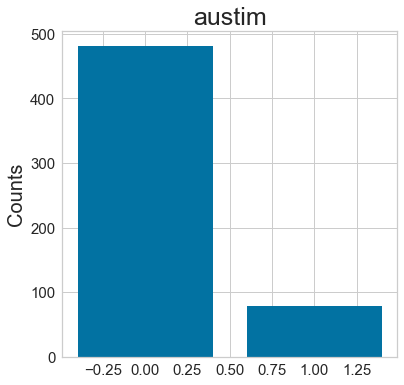

In [21]:
# Histograms to review data and confirm absence of outliers in data
plt.rcParams['figure.figsize'] = (6,6)
for col in x_train.columns:
    x = x_train.groupby(col).size().reset_index(name='Counts')[col]
    y = x_train.groupby(col).size().reset_index(name='Counts')['Counts']
    plt.bar(x, y)
    plt.title(col, fontsize=25)
    plt.ylabel('Counts', fontsize=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()